# Analysis of persistence homology for molecules

What actually is this stuff that I'm playing around with

small modlecules with pdb structures
https://ww2.chemistry.gatech.edu/~lw26/structure/small_molecules/index.html

In [1]:
# lets load our libraries
#!conda install -y -c conda-forge numpy=1.19.5
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf
import os
import sys
import rdkit
import h5py

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from collections import Counter

print("TensorFlow version: " + tf.__version__)

# topology stuff 
from gtda.mapper import plot_interactive_mapper_graph
from gtda.plotting import plot_point_cloud, plot_betti_curves
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import Amplitude
from sklearn.pipeline import make_union, Pipeline

# fixc this at some point
sys.path.append(r"C:\Users\ella_\Documents\GitHub\graphs_and_topology_for_chemistry")
sys.path.append(r"C:\Users\ella_\Documents\GitHub\icosahedron_projection")

results_dir = r"F:\Nextcloud\science\results\topology_and_graphs"

#import projection
#from projection.molecule import Molecule
#from projection.pdbmolecule import PDBMolecule
#from projection.mol2molecule import Mol2Molecule

import helper_functions as h
#from projection.face import Face

TensorFlow version: 2.7.0


In [2]:
def generate_structure_from_smiles(smiles):

    # Generate a 3D structure from smiles

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates 

def smiles_to_persistence_diagrams(smiles):
    coords=generate_structure_from_smiles(smiles)
    # makes a point cloud version of the structure
    # there are no atom types

    # Track connected components, loops, and voids
    homology_dimensions = [0, 1, 2]

    # Collapse edges to speed up H2 persistence calculation!
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=homology_dimensions,
        n_jobs=6,
        collapse_edges=True,
    )
    reshaped_coords=coords[None, :, :]
    diagrams_basic = persistence.fit_transform(reshaped_coords)
    return coords, diagrams_basic

def generate_structure_from_pdb(data_dir,
                               filename):

    # Generate a 3D structure from smiles

    mol = rdkit.Chem.rdmolfiles.MolFromPDBFile(
        os.path.join(data_dir, filename))
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates 

def generate_structure_from_mol(data_dir,
                               filename):

    # Generate a 3D structure from smiles

    mol = rdkit.Chem.rdmolfiles.MolFromMolFile(
        os.path.join(data_dir, filename))
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates

def coords_to_persistence_diagrams(coords):
    # makes a point cloud version of the structure
    # there are no atom types

    # Track connected components, loops, and voids
    homology_dimensions = [0, 1, 2]

    # Collapse edges to speed up H2 persistence calculation!
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=homology_dimensions,
        n_jobs=6,
        collapse_edges=True,
    )
    reshaped_coords=coords[None, :, :]
    diagrams_basic = persistence.fit_transform(reshaped_coords)
    return coords, diagrams_basic

## Testing out some simple compounds

In [3]:
benzene = rdkit.Chem.MolFromSmiles("c1ccccc1")
benzene_smiles = "c1ccccc1"
cyclohexane = rdkit.Chem.MolFromSmiles("C1CCCCC1")
cyclohexane_smiles = "C1CCCCC1"
pyridine = rdkit.Chem.MolFromSmiles("n1ccccc1") 
pyridine_smiles = "n1ccccc1"
furan = rdkit.Chem.MolFromSmiles("o1cccc1")
furan_smiles = "o1cccc1"

bucky_ball_smiles = "c12c3c4c5c1c1c6c7c2c2c8c3c3c9c4c4c%10c5c5c1c1c6c6c%11c7c2c2c7c8c3c3c8c9c4c4c9c%10c5c5c1c1c6c6c%11c2c2c7c3c3c8c4c4c9c5c1c1c6c2c3c41"
bucky_ball= rdkit.Chem.MolFromSmiles(bucky_ball_smiles)
bucky_ball
S_alanine_smiles='C[C@@H](C(=O)O)N'
S_alanine = rdkit.Chem.MolFromSmiles(S_alanine_smiles)
D_alanine_smiles='C[C@H](C(=O)O)N'
D_alanine = rdkit.Chem.MolFromSmiles(D_alanine_smiles)
hexane_smiles = 'CCCCCC'
hexane= rdkit.Chem.MolFromSmiles('CCCCCC')


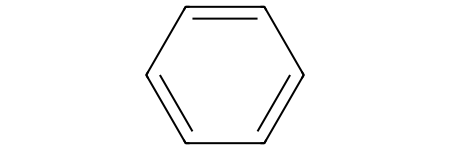

In [4]:
benzene

### Benzene
It looks like information about the bond lengths are included.

In [76]:
coords, diagrams_basic = smiles_to_persistence_diagrams(benzene_smiles)
plot_point_cloud(coords)

In [77]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

This is interesting, there are 6 CH bonds at about 1.09A, and we have 6 features dying at 1.08, these are teh bonds. Then we have the C=C bonds dying at 1.39, 6-1 cos the remaining feature is the ring, which dies at 1.399 and then I think the entire thing collapes into a point at 2.42

In [78]:
diagrams_basic

array([[[0.        , 1.08233905, 0.        ],
        [0.        , 1.08233905, 0.        ],
        [0.        , 1.08233905, 0.        ],
        [0.        , 1.08233905, 0.        ],
        [0.        , 1.08233905, 0.        ],
        [0.        , 1.08233905, 0.        ],
        [0.        , 1.39904296, 0.        ],
        [0.        , 1.39904296, 0.        ],
        [0.        , 1.39904296, 0.        ],
        [0.        , 1.39904296, 0.        ],
        [0.        , 1.39904296, 0.        ],
        [1.39904296, 2.42321348, 1.        ],
        [2.42321348, 2.79808593, 2.        ]]])

In [79]:
x_val_a = [x for x in diagrams_basic[0][:,0]]
x_val_b = [x for x in diagrams_basic[0][:,1]]
y_val = [-x for x in range(len(x_val_a))]
col = [int(x) for x in diagrams_basic[0][:,2]]

In [80]:
col=['r','r','r','r','r','r','r','r','r','r','r','b','g']

([], [])

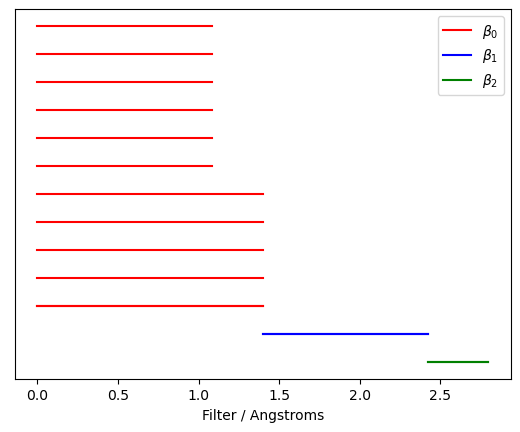

In [108]:
for i in range(3,0,-1):
    plt.plot([x_val_a[-i],x_val_b[-i]],[y_val[-i],y_val[-i]], c=col[-i])
plt.legend([r'$\beta_0$',r'$\beta_1$',r'$\beta_2$'])
for i in range(len(x_val_a)):
    plt.plot([x_val_a[i],x_val_b[i]],[y_val[i],y_val[i]], c=col[i])
plt.xlabel('Filter / Angstroms')
plt.yticks([])


In [11]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

(1, 3)

In [12]:
X_basic

array([[3.44756289, 0.        , 0.        ]])

In [13]:
from gtda.diagrams import Amplitude

Amplitude(metric='bottleneck').fit_transform(diagrams_basic)

array([[0.69952154, 0.51208508, 0.1874361 ]])

In [14]:
Amplitude(metric='wasserstein').fit_transform(diagrams_basic)

array([[2.05032622, 0.51208508, 0.1874361 ]])

In [15]:
Amplitude(metric='landscape').fit_transform(diagrams_basic)

array([[0.47767647, 0.29918885, 0.066254  ]])

In [16]:
Amplitude(metric='persistence_image').fit_transform(diagrams_basic)

array([[12.81174379,  1.4666147 ,  0.        ]])

In [17]:
from gtda.diagrams import NumberOfPoints

# Reshape single diagram to (n_samples, n_features, 3) format
diagram = diagrams_basic[0][None, :, :]
# Get number of points for (H0, H1, H2)
NumberOfPoints().fit_transform(diagram)

array([[11,  1,  1]], dtype=int64)

In [128]:
from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)
feature_union

FeatureUnion(transformer_list=[('persistenceentropy',
                                PersistenceEntropy(normalize=True)),
                               ('numberofpoints', NumberOfPoints(n_jobs=-1)),
                               ('amplitude-1',
                                Amplitude(metric='bottleneck', n_jobs=-1)),
                               ('amplitude-2',
                                Amplitude(metric='wasserstein', n_jobs=-1)),
                               ('amplitude-3', Amplitude(n_jobs=-1)),
                               ('amplitude-4',
                                Amplitude(metric='persistence_image',
                                          n_jobs=-1))])

In [129]:
from gtda.pipeline import Pipeline
from gtda.mapper import plot_interactive_mapper_graph
steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=[0,1,2], n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestRegressor(oob_score=True)),
]

pipeline = Pipeline(steps)

In [20]:
plot_interactive_mapper_graph(pipeline, coords)

AttributeError: 'Pipeline' object has no attribute 'get_mapper_params'

In [109]:
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance

BC = BettiCurve()

X_betti_curves = BC.fit_transform(diagrams_basic)

BC.plot(X_betti_curves)

In [ ]:
X_betti_curves

## pyridine

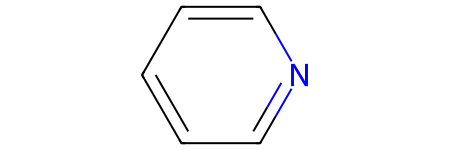

In [22]:
pyridine

In [68]:
coords, diagrams_basic = smiles_to_persistence_diagrams(pyridine_smiles)
plot_point_cloud(coords)

In [69]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

In [70]:
BC = BettiCurve()

X_betti_curves = BC.fit_transform(diagrams_basic)

BC.plot(X_betti_curves)

Pyridine values:
5 CH at around 1.08, but they are not exactly the same, 2 pairs, 2 pairs and one, this is the pairs of C-H, so this method is capturing the difference between different environments.
Then 2 at 1.36, then 2 at 1.39, one at 1.39ish - that's gotta be 5 of the 6 C-C or C-N bonds (the ring)
then ring close and 
molecule become a blob

In [25]:
diagrams_basic

array([[[0.        , 1.08179998, 0.        ],
        [0.        , 1.08179998, 0.        ],
        [0.        , 1.08231032, 0.        ],
        [0.        , 1.08231032, 0.        ],
        [0.        , 1.08233058, 0.        ],
        [0.        , 1.36050916, 0.        ],
        [0.        , 1.36050928, 0.        ],
        [0.        , 1.39675403, 0.        ],
        [0.        , 1.39675403, 0.        ],
        [0.        , 1.39756441, 0.        ],
        [1.39756441, 2.41083002, 1.        ],
        [2.41668129, 2.7617209 , 2.        ]]])

## furan

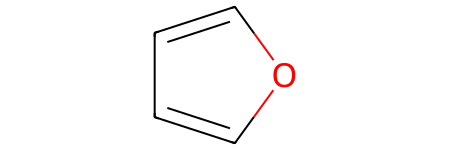

In [71]:
furan

In [72]:
coords, diagrams_basic = smiles_to_persistence_diagrams(furan_smiles)
plot_point_cloud(coords)

In [73]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

The blob is still present but has no x,y coords so not on the plot, I have no idea what this means

In [74]:
diagrams_basic

array([[[0.        , 1.08174658, 0.        ],
        [0.        , 1.08174658, 0.        ],
        [0.        , 1.08177471, 0.        ],
        [0.        , 1.08177471, 0.        ],
        [0.        , 1.31312513, 0.        ],
        [0.        , 1.31312513, 0.        ],
        [0.        , 1.37776423, 0.        ],
        [0.        , 1.37902129, 0.        ],
        [1.37902129, 2.2005055 , 1.        ],
        [0.        , 0.        , 2.        ]]])

In [75]:
BC = BettiCurve()

X_betti_curves = BC.fit_transform(diagrams_basic)

BC.plot(X_betti_curves)

## cyclohexane
you need to do this with boat and chair conformation

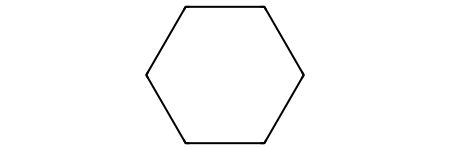

In [30]:
cyclohexane

In [31]:
coords, diagrams_basic = smiles_to_persistence_diagrams(cyclohexane_smiles)
plot_point_cloud(coords)

In [32]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

The blob is still present but has no x,y coords so not on the plot, I have no idea what this means

In [33]:
diagrams_basic

array([[[0.        , 1.11122668, 0.        ],
        [0.        , 1.1112268 , 0.        ],
        [0.        , 1.11122692, 0.        ],
        [0.        , 1.11122692, 0.        ],
        [0.        , 1.11122751, 0.        ],
        [0.        , 1.11122763, 0.        ],
        [0.        , 1.11231828, 0.        ],
        [0.        , 1.11231863, 0.        ],
        [0.        , 1.11231887, 0.        ],
        [0.        , 1.11231935, 0.        ],
        [0.        , 1.11231959, 0.        ],
        [0.        , 1.11231959, 0.        ],
        [0.        , 1.53396952, 0.        ],
        [0.        , 1.53397   , 0.        ],
        [0.        , 1.53397024, 0.        ],
        [0.        , 1.53397024, 0.        ],
        [0.        , 1.53397036, 0.        ],
        [1.53397048, 2.52883244, 1.        ],
        [2.64888835, 2.81706333, 2.        ],
        [2.64888453, 2.81706142, 2.        ],
        [2.52883267, 2.95771074, 2.        ]]])

## hexane
Ok, so hexane is not laid out like in the formula as the UFF minimises it and it curls up and as such has a very similar persistence plot to cyclohexane.

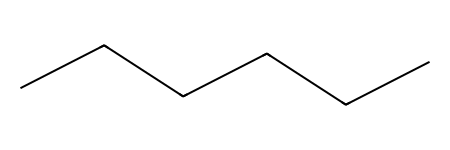

In [34]:
hexane

In [35]:
coords, diagrams_basic = smiles_to_persistence_diagrams(hexane_smiles)
plot_point_cloud(coords)

In [36]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

2 lots of 5 bond there (so 6?)

In [37]:
diagrams_basic

array([[[0.        , 1.10954607, 0.        ],
        [0.        , 1.11038911, 0.        ],
        [0.        , 1.1103915 , 0.        ],
        [0.        , 1.11074555, 0.        ],
        [0.        , 1.1108923 , 0.        ],
        [0.        , 1.11089373, 0.        ],
        [0.        , 1.11101913, 0.        ],
        [0.        , 1.11162734, 0.        ],
        [0.        , 1.11171043, 0.        ],
        [0.        , 1.11190736, 0.        ],
        [0.        , 1.11194205, 0.        ],
        [0.        , 1.11217642, 0.        ],
        [0.        , 1.11225986, 0.        ],
        [0.        , 1.11233354, 0.        ],
        [0.        , 1.52599394, 0.        ],
        [0.        , 1.52845299, 0.        ],
        [0.        , 1.53315163, 0.        ],
        [0.        , 1.53585935, 0.        ],
        [0.        , 1.53645003, 0.        ],
        [2.33774829, 2.84413981, 1.        ],
        [0.        , 0.        , 2.        ]]])

## S-alanine
No difference between S and D alanine, as chirality is not conserved in topologuy

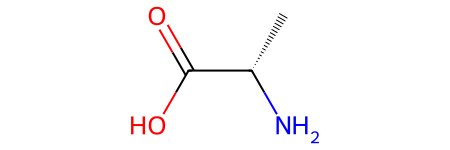

In [38]:
S_alanine

In [39]:
coords, diagrams_basic = smiles_to_persistence_diagrams(S_alanine_smiles)
plot_point_cloud(coords)

In [40]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

The blob is still present but has no x,y coords so not on the plot, I have no idea what this means

In [41]:
diagrams_basic

array([[[0.        , 1.01297867, 0.        ],
        [0.        , 1.04626501, 0.        ],
        [0.        , 1.0464859 , 0.        ],
        [0.        , 1.11076975, 0.        ],
        [0.        , 1.11127329, 0.        ],
        [0.        , 1.11146152, 0.        ],
        [0.        , 1.11434066, 0.        ],
        [0.        , 1.26019466, 0.        ],
        [0.        , 1.39212   , 0.        ],
        [0.        , 1.46284556, 0.        ],
        [0.        , 1.5017091 , 0.        ],
        [0.        , 1.53002214, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

In [42]:
S_Ala=diagrams_basic

## D-alanine
you need to do this with boat and chair conformation

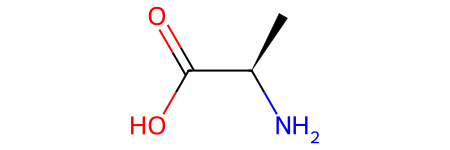

In [43]:
D_alanine

In [44]:
coords, diagrams_basic = smiles_to_persistence_diagrams(D_alanine_smiles)
plot_point_cloud(coords)

In [45]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

The blob is still present but has no x,y coords so not on the plot, I have no idea what this means

In [46]:
diagrams_basic

array([[[0.        , 1.01301861, 0.        ],
        [0.        , 1.04634714, 0.        ],
        [0.        , 1.04660726, 0.        ],
        [0.        , 1.11080253, 0.        ],
        [0.        , 1.11117733, 0.        ],
        [0.        , 1.11131895, 0.        ],
        [0.        , 1.11255383, 0.        ],
        [0.        , 1.26088107, 0.        ],
        [0.        , 1.39140248, 0.        ],
        [0.        , 1.4642005 , 0.        ],
        [0.        , 1.50563633, 0.        ],
        [0.        , 1.52968895, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

In [47]:
D_Ala=diagrams_basic

In [48]:
S_Ala - D_Ala

array([[[ 0.00000000e+00, -3.99351120e-05,  0.00000000e+00],
        [ 0.00000000e+00, -8.21352005e-05,  0.00000000e+00],
        [ 0.00000000e+00, -1.21355057e-04,  0.00000000e+00],
        [ 0.00000000e+00, -3.27825546e-05,  0.00000000e+00],
        [ 0.00000000e+00,  9.59634781e-05,  0.00000000e+00],
        [ 0.00000000e+00,  1.42574310e-04,  0.00000000e+00],
        [ 0.00000000e+00,  1.78682804e-03,  0.00000000e+00],
        [ 0.00000000e+00, -6.86407089e-04,  0.00000000e+00],
        [ 0.00000000e+00,  7.17520714e-04,  0.00000000e+00],
        [ 0.00000000e+00, -1.35493279e-03,  0.00000000e+00],
        [ 0.00000000e+00, -3.92723083e-03,  0.00000000e+00],
        [ 0.00000000e+00,  3.33189964e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

## Cyclohexane boat / chair

# boat first!

In [49]:
rdkit.Chem.rdmolfiles.MolFromPDBFile(os.path.join(results_dir, "cyclohexaneboat.pdb"))

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\cyclohexaneboat.pdb

In [50]:
coords = generate_structure_from_pdb(results_dir,
                            "cyclohexaneboat.pdb")

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\cyclohexaneboat.pdb

In [51]:
coords, diagrams_basic = coords_to_persistence_diagrams(coords)

In [52]:
plot_point_cloud(coords)

In [53]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

In [54]:
diagrams_basic

array([[[0.        , 1.01301861, 0.        ],
        [0.        , 1.04634714, 0.        ],
        [0.        , 1.04660726, 0.        ],
        [0.        , 1.11080253, 0.        ],
        [0.        , 1.11117733, 0.        ],
        [0.        , 1.11131895, 0.        ],
        [0.        , 1.11255383, 0.        ],
        [0.        , 1.26088107, 0.        ],
        [0.        , 1.39140248, 0.        ],
        [0.        , 1.4642005 , 0.        ],
        [0.        , 1.50563633, 0.        ],
        [0.        , 1.52968895, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

In [55]:
boat_diag_basic = diagrams_basic

## Cyclohexane chair

In [56]:
rdkit.Chem.rdmolfiles.MolFromPDBFile(os.path.join(results_dir, "cyclohexanechair.pdb"))

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\cyclohexanechair.pdb

In [57]:
coords = generate_structure_from_pdb(results_dir,
                            "cyclohexanechair.pdb")

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\cyclohexanechair.pdb

In [58]:
coords, diagrams_basic = coords_to_persistence_diagrams(coords)

In [59]:
plot_point_cloud(coords)

In [60]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

In [61]:
diagrams_basic

array([[[0.        , 1.01301861, 0.        ],
        [0.        , 1.04634714, 0.        ],
        [0.        , 1.04660726, 0.        ],
        [0.        , 1.11080253, 0.        ],
        [0.        , 1.11117733, 0.        ],
        [0.        , 1.11131895, 0.        ],
        [0.        , 1.11255383, 0.        ],
        [0.        , 1.26088107, 0.        ],
        [0.        , 1.39140248, 0.        ],
        [0.        , 1.4642005 , 0.        ],
        [0.        , 1.50563633, 0.        ],
        [0.        , 1.52968895, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

The two digrams have different numbers of points so obviously are different

# Buckyball

In [132]:
egg=rdkit.Chem.rdmolfiles.MolFromPDBFile(os.path.join(results_dir, "c_60.pdb"))
egg

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\c_60.pdb

In [63]:
coords = generate_structure_from_pdb(results_dir,
                            "c_60.pdb")

OSError: Bad input file F:\Nextcloud\science\results\topology_and_graphs\c_60.pdb

In [64]:
coords, diagrams_basic = coords_to_persistence_diagrams(coords)

In [65]:
plot_point_cloud(coords)

In [66]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

In [67]:
diagrams_basic

array([[[0.        , 1.01301861, 0.        ],
        [0.        , 1.04634714, 0.        ],
        [0.        , 1.04660726, 0.        ],
        [0.        , 1.11080253, 0.        ],
        [0.        , 1.11117733, 0.        ],
        [0.        , 1.11131895, 0.        ],
        [0.        , 1.11255383, 0.        ],
        [0.        , 1.26088107, 0.        ],
        [0.        , 1.39140248, 0.        ],
        [0.        , 1.4642005 , 0.        ],
        [0.        , 1.50563633, 0.        ],
        [0.        , 1.52968895, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

The two digrams have different numbers of points so obviously are different

## stuff for barcode plots

In [126]:
for i in range(30,0,-5):
    print(i)

30
25
20
15
10
5


In [ ]:
import sklearn
sklearn.datasets.

In [122]:
from sklearn.datasets.data.generate_datasets import make_point_clouds



point_clouds_basic, labels_basic = make_point_clouds(
    n_samples_per_shape=10, 
    n_points=20, 
    noise=0.5)



plot_point_cloud(point_clouds_basic[10])

ModuleNotFoundError: No module named 'sklearn.datasets.data.generate_datasets'

In [ ]:
'''
Created by Thiago de Melo
'''


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess
#import os

def circle_pts(N, R=1):
    theta_list = np.random.random_sample(N)
    pts = np.zeros((N,2))
    #print theta_list
    for i in range(len(theta_list)):
        pts[i,0] = R*np.cos(2*np.pi*theta_list[i])
        pts[i,1] = R*np.sin(2*np.pi*theta_list[i])
    return pts

def sphere_pts(N, R=1):
    angle_list = 2*np.pi * np.random.sample((N,2))
    #phi_list   = np.random.random_sample(N)
    pts = np.zeros((N,3))
    for i in range(len(angle_list)):
        pts[i,0] = R*np.cos(angle_list[i,0])*np.cos(angle_list[i,1])
        pts[i,1] = R*np.cos(angle_list[i,0])*np.sin(angle_list[i,1])
        pts[i,2] = R*np.sin(angle_list[i,0])
    return pts

def figure_eight_pts(N, a=1):
    theta_list = 2 * np.pi * np.random.sample(N)
    pts = np.zeros((N,2))
    print(theta_list)
    for i in range(len(theta_list)):
        pts[i,0] = a * np.cos(theta_list[i]) * np.sqrt(2*np.cos(2*theta_list[i]))
        pts[i,1] = a * np.sin(theta_list[i]) * np.sqrt(2*np.cos(2*theta_list[i]))
    return pts

def annulus_pts(N, R=2, r=1):
    theta_list = np.random.random_sample(N)
    radius_list = r + np.random.random_sample(N) * (R-r)
    pts = np.zeros((N,2))
    for i in range(len(theta_list)):
        pts[i,0] = radius_list[i] * np.cos(2*np.pi*theta_list[i])
        pts[i,1] = radius_list[i] * np.sin(2*np.pi*theta_list[i])
    return pts

def random_pts(N,d):
    pts = np.random.random_sample((N, d))
    return pts

def cube_pts(N):
    npts = N/6
    faces = {}
    for i in range(3):
        data0 = np.random.random((npts,3))
        data1 = np.random.random((npts,3))
        data0[:,i] = 0
        data1[:,i] = 1
        faces[i]   = data0
        faces[i+3] = data1
    cube = np.concatenate([faces[i] for i in range(6)])
    return cube

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

def plot_bar(p,q,c='b',linestyle='-'):
    plt.plot([p[0],q[0]],[p[1],q[1]], c=c,linestyle=linestyle, linewidth=1)


''' DATA SET SECTION '''
''' cant use dash - in variable name (use _ instead)'''
VR = './examples/VR.point_cloud'
mds_weight = './examples/mds-weight.point_cloud'
mds_size = './examples/mds-size.point_cloud'
input_file = mds_weight
pts_file = './pts.point_cloud'

'''choose pts below'''
#pts = np.loadtxt(input_file, delimiter=',')
pts = circle_pts(50, 2)
#pts = annulus_pts(400, 4, 1)
#pts = random_pts(100,3)
#pts = cube_pts(30)
#pts = figure_eight_pts(400, 3)
#pts = sphere_pts(100)

np.savetxt(pts_file, pts, delimiter=' ', fmt='%.3f')
num_pts, dim_pts = pts.shape

#print pts

#plt.scatter(pts[:,0],pts[:,1])
#plt.show()
#quit()

''' RIPSER SECTION '''
ripser_bin = ['/home/thiago/Dropbox/Programacao/ripser/ripser']
ripser_input_file = pts_file
ripser_output_file = 'ripser.out'
ripser_format = 'point-cloud'
ripser_threshold = 1.4
ripser_dim = 2
ripser_opt = ['--format', ripser_format, '--threshold', str(ripser_threshold), '--dim', str(ripser_dim), '--output', ripser_output_file, ripser_input_file]
ripser_cmd = ripser_bin + ripser_opt

print("Executing Ripser...")
subprocess.call(ripser_cmd),
print("Done!")

#quit()

''' DIAGRAMS SECTION '''
cols_name = ['dim', 'birth', 'death']
df = pd.read_csv(ripser_output_file, delim_whitespace = True, header = None, names = cols_name)
dimensions = df.drop_duplicates('dim')['dim'].tolist()
birth_max = df['birth'].max()
death_max = df['death'].max()
infinity = ripser_threshold #1.05 * np.maximum(birth_max,death_max)
print("Creating persistent diagram for dimensions", dimensions)

diagrams = {} 
diagrams_inf = {}
bar_num = {}
bar_inf_num = {}
for dim in dimensions:
    diagrams[dim] = df[ (df.dim == dim) & (df.death != -1) ]
    diagrams[dim] = diagrams[dim].sort_values(['birth','death'], ascending=[True,True]).reset_index()
    diagrams_inf[dim] = df[ (df.dim == dim) & (df.death == -1) ]
    diagrams_inf[dim] = diagrams_inf[dim].sort_values(['birth','death'], ascending=[True,True]).reset_index()
    bar_num[dim] = diagrams[dim].shape[0]
    bar_inf_num[dim] = diagrams_inf[dim].shape[0]
    #print dim, bar_num[dim], bar_inf_num[dim]
    #print diagrams[dim]


''' PLOTS SECTION '''

#'''
fig = plt.figure()

# dataset
if dim_pts >= 3:
    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.plot3D(pts[:,0],pts[:,1],pts[:,2],".")
    ax.set_title(r'$X$ with $%d$ points' % num_pts, fontsize = 10)
    ax.set_zticks([1])
    ax.set_yticks([0,1])
    ax.set_xticks([0,1])
if dim_pts == 2:
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(r'$X$ with $%d$ points' % num_pts, fontsize = 10)
    plt.scatter(pts[:,0],pts[:,1], s=10)
if dim_pts == 1:
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(r'$X$ with $%d$ points' % num_pts, fontsize = 10)
    plt.scatter(pts,0*pts, s=10)


# diagrams
ax = fig.add_subplot(1, 2, 1)
ax.set_title(r'$\mathrm{Dgm}_k(X)$  $\epsilon = %.2f$' % float(ripser_threshold), fontsize = 10)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('birth', fontsize=10)
plt.ylabel('death', fontsize=10)
adjust_spines(ax, ['left', 'bottom'])
plt.plot([0,infinity],[0,infinity], c='k', linewidth=1)
colors = ['r', 'b', 'g']
markers = ['o', 's', 'x']
labels = [r'$k = %d$' % x for x in range(len(dimensions))]

for dim in dimensions:
    #print diagrams_inf[dim]
    plt.scatter(diagrams[dim].birth, diagrams[dim].death, s=10, c=colors[dim], label=labels[dim], marker=markers[dim])
    if len(diagrams_inf[dim].index) > 0:
        plt.scatter(diagrams_inf[dim].birth, -infinity*diagrams_inf[dim].death, s=15, c=colors[dim], marker=markers[dim], label='') 
plt.legend(loc="lower right")


# barcodes
for dim in dimensions:
    print("Number of bars in dimension %d: %d" % (dim, bar_num[dim] + bar_inf_num[dim]))
    fig = plt.figure()
    ax = plt.subplot("111")
    ax.set_title("%d-dimensional bars: %d finite, %d infinite" % (dim, bar_num[dim], bar_inf_num[dim]), fontsize = 10)
    # infinite bars
    if bar_inf_num[dim] > 0:
        for i in range(bar_inf_num[dim]):
                h=i+bar_num[dim]
                plot_bar([diagrams_inf[dim].birth[i],h],[-infinity*diagrams_inf[dim].death[i],h])
                plt.scatter([-infinity*diagrams_inf[dim].death[i]],[h], c='b', s=10, marker='>')
    # finite bars
    if bar_num[dim] > 0:
        for i in range(bar_num[dim]):
                plot_bar([diagrams[dim].birth[i],i],[diagrams[dim].death[i],i])
                plt.plot([diagrams[dim].death.max(),diagrams[dim].death.max()],[0,bar_num[dim]], c='r', linestyle='--', linewidth=0.5)
        #plt.xticks(list(plt.xticks()[0]) + [diagrams[dim].death.max()])

plt.show()
#'''



In [130]:
egg = ['SMR_VSA6', 'FpDensityMorgan2', 'Chi3n', 'MinPartialCharge', 'HeavyAtomMolWt', 'PEOE_VSA1', 'Chi4n', 'MaxEStateIndex', 'NumAliphaticHeterocycles', 'MinEStateIndex', 'Chi4v', 'SlogP_VSA12', 'qed', 'MinAbsPartialCharge', 'MolLogP', 'VSA_EState5', 'SMR_VSA10', 'Chi2n', 'NumSaturatedCarbocycles', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'PEOE_VSA7', 'VSA_EState7', 'PEOE_VSA5', 'NumHAcceptors', 'SMR_VSA8', 'Kappa3', 'VSA_EState3', 'NumRotatableBonds', 'NumAliphaticRings', 'NOCount', 'MaxAbsEStateIndex', 'TPSA', 'VSA_EState6', 'NumAromaticRings', 'NumAromaticCarbocycles', 'SlogP_VSA4', 'FpDensityMorgan3', 'SlogP_VSA2', 'PEOE_VSA10', 'FpDensityMorgan3', 'SlogP_VSA8', 'PEOE_VSA9', 'NumSaturatedRings', 'NumAromaticHeterocycles', 'SlogP_VSA5', 'SlogP_VSA3', 'Chi2v', 'PEOE_VSA3', 'NumHAcceptors']

In [131]:
len(egg)

50

In [133]:
egg2=['FpDensityMorgan2', 'Chi3n', 'MinPartialCharge', 'HeavyAtomMolWt', 'PEOE_VSA1', 'Chi4n', 'MaxEStateIndex', 'NumAliphaticHeterocycles', 'MinEStateIndex', 'Chi4v', 'SlogP_VSA12', 'qed', 'MinAbsPartialCharge', 'MolLogP', 'VSA_EState5', 'SMR_VSA10', 'Chi2n', 'NumSaturatedCarbocycles', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'PEOE_VSA7', 'VSA_EState7', 'PEOE_VSA5', 'NumHAcceptors', 'SMR_VSA8', 'Kappa3', 'VSA_EState3', 'NumRotatableBonds', 'NumAliphaticRings', 'NOCount', 'MaxAbsEStateIndex', 'TPSA', 'VSA_EState6', 'NumAromaticRings', 'NumAromaticCarbocycles', 'SlogP_VSA4', 'FpDensityMorgan3', 'SlogP_VSA2', 'PEOE_VSA10', 'FpDensityMorgan3', 'SlogP_VSA8', 'PEOE_VSA9', 'NumSaturatedRings', 'NumAromaticHeterocycles', 'SlogP_VSA5', 'SlogP_VSA3', 'Chi2v', 'PEOE_VSA3', 'NumHAcceptors']

In [134]:
len(egg2)

49